In [ ]:
# Clean + reinstall environment for YOLOv8 training (Colab-safe)

!pip -q install --upgrade pip

# Remove any conflicting or precompiled wheels
!pip uninstall -y ultralytics roboflow opencv-python numpy

# Reinstall matching, compatible versions
!pip -q install "numpy==1.26.4" "ultralytics==8.3.204" "roboflow==1.1.47" "opencv-python==4.10.0.84"

import torch, cv2, platform
from ultralytics import YOLO, __version__ as yolo_version

print(f"Python: {platform.python_version()}")
print(f"Torch: {torch.__version__}  | CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}  | VRAM: {torch.cuda.get_device_properties(0).total_memory/(1024**3):.1f} GB")
print(f"OpenCV: {cv2.__version__}  |  Ultralytics: {yolo_version}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.7 MB/s eta 0:00:00
Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/

### 1. ***Mathematical Foundations***
   - I'm ensuring I understand the mathematical backbone before I get too deep Thus, I'm coding the IoU and

In [ ]:
# Cell 2 — IoU (intersection over union) intuition

def iou_xyxy(boxA, boxB):
    """
    Compute IoU for two boxes in [x1, y1, x2, y2] pixel form.
    """
    # intersection
    xA, yA = max(boxA[0], boxB[0]), max(boxA[1], boxB[1]) # Top edges are the Max (Xa - left , yA - top )
    xB, yB = min(boxA[2], boxB[2]), min(boxA[3], boxB[3]) # Bottom edges are the Min (xB - right, yB -bottom)
    inter_w, inter_h = max(0, xB - xA), max(0, yB - yA) # If the boxes dont overlap, the answer is 0
    inter_area = inter_w * inter_h # Area of overlap

    # individual areas
    areaA = max(0, (boxA[2] - boxA[0])) * max(0, (boxA[3] - boxA[1])) # width of intersection * height of intersection
    areaB = max(0, (boxB[2] - boxB[0])) * max(0, (boxB[3] - boxB[1]))# width of intersection * height of intersection

    # union and IoU
    union = areaA + areaB - inter_area + 1e-9 # Avoid division by 0, union is the area of box and b combined - overlap
    iou = inter_area / union # The intersection over union
    return iou

# quick test
b1 = [10, 10, 50, 50]
b2 = [20, 20, 60, 60]
print("IoU:", round(iou_xyxy(b1, b2), 3))


IoU: 0.391


### YOLO Coordinate Math

YOLO stores bounding boxes in **normalized format**:
$$[c_x, c_y, w, h]$$
All values are in **[0, 1]**, relative to image width \(W\) and height \(H\).

---

####  To convert to pixel coordinates
$$
x_1 = (c_x - \tfrac{w}{2})W,\quad
y_1 = (c_y - \tfrac{h}{2})H \\
x_2 = (c_x + \tfrac{w}{2})W,\quad
y_2 = (c_y + \tfrac{h}{2})H
$$

- Subtract/add half the width & height to shift from **center** → **corners**.  
- Multiply by \(W,H\) to scale to pixel space.

---

####  To convert back to YOLO format
$$
c_x = \frac{x_1 + x_2}{2W},\quad
c_y = \frac{y_1 + y_2}{2H} \\
w = \frac{x_2 - x_1}{W},\quad
h = \frac{y_2 - y_1}{H}
$$

---

#### Why
Normalization makes labels:
- Resolution-independent
- Easier for the model to predict (values ∈ [0, 1])
- Robust to resizing & augmentation


In [ ]:
# Cell 3 — Convert between YOLO normalized format and pixel coordinates

def yolo_to_xyxy(cx, cy, w, h, W, H):
    """
    Convert YOLO format [cx, cy, w, h] normalized (0–1)
    into pixel coordinates [x1, y1, x2, y2].
    cx, cy, w, h: center_x, center_y, width, height (normalized)
    W, H: image width and height in pixels
    """
    x1 = (cx - w/2) * W
    y1 = (cy - h/2) * H
    x2 = (cx + w/2) * W
    y2 = (cy + h/2) * H
    return [x1, y1, x2, y2]


def xyxy_to_yolo(x1, y1, x2, y2, W, H):
    """
    Convert pixel coordinates [x1, y1, x2, y2]
    back to YOLO normalized [cx, cy, w, h].
    """
    w = (x2 - x1) / W
    h = (y2 - y1) / H
    cx = (x1 + x2) / (2 * W)
    cy = (y1 + y2) / (2 * H)
    return [cx, cy, w, h]


# Example: assume a 640x480 image
W, H = 640, 480
box_yolo = [0.5, 0.5, 0.25, 0.25]  # centered, quarter of image size
box_pix = yolo_to_xyxy(*box_yolo, W, H)
print("YOLO → pixel:", box_pix)

# convert back
print("pixel → YOLO:", xyxy_to_yolo(*box_pix, W, H))


YOLO → pixel: [240.0, 180.0, 400.0, 300.0]
pixel → YOLO: [0.5, 0.5, 0.25, 0.25]


### Non-Max Suppression (NMS) Math and Logic

NMS removes multiple overlapping detections of the same object by keeping only the box with the highest confidence score.

---

#### Step 1: Sort by confidence
Given a list of boxes \( B_i = [x_1, y_1, x_2, y_2] \) and their confidence scores \( s_i \),
sort all boxes in descending order of \( s_i \).

---

#### Step 2: Select highest-confidence box
Take the top-scoring box \( B_k \) and compare it with the remaining boxes.

For each other box \( B_j \), compute the Intersection over Union:

$$
\text{IoU}(B_k, B_j) = \frac{|B_k \cap B_j|}{|B_k \cup B_j|}
$$

---

#### Step 3: Suppress overlapping boxes
If $\text{IoU}(B_k, B_j) > t$ (the threshold, typically 0.5),  
then \( B_j \) is considered a duplicate and is removed.

Keep \( B_k \) in the final list.

---

#### Step 4: Repeat
Continue the process with the next highest-confidence box among the remaining ones until none are left.

---

#### Intuition
- High IoU → boxes refer to the same object → keep one.
- Low IoU → boxes refer to different objects → keep both.

---

#### Formula summary
$$
\text{Kept} = \{ B_k \mid \forall j, \ \text{IoU}(B_k, B_j) < t \ \text{or} \ s_k > s_j \}
$$


In [ ]:
# Cell 4 — Non-Max Suppression (NMS) intuition demo
# Removes overlapping boxes that likely refer to the same object

def iou_xyxy(a, b):
    xA, yA = max(a[0], b[0]), max(a[1], b[1])
    xB, yB = min(a[2], b[2]), min(a[3], b[3])
    inter_w, inter_h = max(0, xB - xA), max(0, yB - yA)
    inter_area = inter_w * inter_h
    area_a = (a[2]-a[0]) * (a[3]-a[1])
    area_b = (b[2]-b[0]) * (b[3]-b[1])
    union = area_a + area_b - inter_area + 1e-9
    return inter_area / union


def nms(boxes, scores, iou_thr=0.5):
    """
    boxes: list of [x1, y1, x2, y2]
    scores: confidence for each box
    iou_thr: IoU threshold for overlap suppression
    """
    idxs = sorted(range(len(boxes)), key=lambda i: scores[i], reverse=True)
    kept = []

    while idxs:
        i = idxs.pop(0)
        kept.append(i)
        idxs = [j for j in idxs if iou_xyxy(boxes[i], boxes[j]) < iou_thr]
    return kept


# --- demo ---
boxes = [
    [10, 10, 50, 50],   # strong overlap with next
    [12, 12, 52, 52],
    [100, 100, 160, 160] # separate object
]
scores = [0.9, 0.85, 0.6]

kept = nms(boxes, scores, iou_thr=0.5)
print("Kept box indices:", kept)
for i in kept:
    print(f"Box {i}: {boxes[i]}, score={scores[i]}")


Kept box indices: [0, 2]
Box 0: [10, 10, 50, 50], score=0.9
Box 2: [100, 100, 160, 160], score=0.6


### Cell 5 — Load RadRoad Dataset via KaggleHub

Download and verify the YOLOv8-formatted RadRoad dataset directly in Colab.

**Steps**
1. Download dataset using KaggleHub (cached automatically).
2. Locate `images/` and `data.yaml`.
3. Verify files exist and print basic stats.
4. Optionally show folder structure.


In [ ]:
# Cell 5 — Load RadRoad Anomaly Detection dataset via KaggleHub (no manual download)

import kagglehub
from pathlib import Path
import os

# 1. Download (cached automatically in Colab)
path = kagglehub.dataset_download("rohitsuresh15/radroad-anomaly-detection")
print("Path to dataset files:", path)

# 2. Locate the YOLOv8 image directory and YAML
data_dir = Path(path) / "images"
yaml_path = data_dir / "data.yaml"

# 3. Verify existence
assert data_dir.exists(), f"Images folder not found at: {data_dir}"
assert yaml_path.exists(), f"data.yaml not found at: {yaml_path}"

print("\nDataset root:", data_dir)
print("YAML path:", yaml_path, "\n")

# 4. Preview YAML and structure
print(yaml_path.read_text())

for split in ["train", "valid", "test"]:
    imgs = len(list((data_dir / split / "images").glob("*")))
    lbls = len(list((data_dir / split / "labels").glob("*")))
    print(f"{split.capitalize()} — images: {imgs}, labels: {lbls}")

# 5. (Optional) show folder structure (one level)
for root, dirs, _ in os.walk(data_dir):
    level = root.replace(str(data_dir), "").count(os.sep)
    if level <= 1:
        print("  " * level + Path(root).name + "/")
    else:
        break


100%|██████████| 7.31G/7.31G [01:35<00:00, 82.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3

Dataset root: /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images
YAML path: /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images/data.yaml 

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 6
names: ['HMV', 'LMV', 'Pedestrian', 'RoadDamages', 'SpeedBump', 'UnsurfacedRoad']


Train — images: 5843, labels: 5843
Valid — images: 1288, labels: 1288
Test — images: 1263, labels: 1263
images/
  train/


In [ ]:
import os

# Get the dataset root path from the output of cell
dataset_root = "/root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images"

print(f"Listing contents of: {dataset_root}")
# List contents of the dataset root directory
for item in os.listdir(dataset_root):
    print(item)

# Optionally, list contents of the train images directory as well
train_images_dir = os.path.join(dataset_root, "train", "images")
if os.path.exists(train_images_dir):
    print(f"\nListing contents of: {train_images_dir} (first 10 items)")
    for i, item in enumerate(os.listdir(train_images_dir)):
        if i < 10:
            print(item)
        else:
            break
else:
    print(f"\nTrain images directory not found at: {train_images_dir}")

Listing contents of: /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images
train
data.yaml
test
valid

Listing contents of: /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images/train/images (first 10 items)
33_13-06-2023_mp4-43_jpg.rf.5c12777d81b2e875f8902e9b0906348a.jpg
29_13-06-2023_mp4-58_jpg.rf.53c07898be103ab4e7bc4de5c96060f4.jpg
34_13-06-2023_mp4-0_jpg.rf.3b81f9ba07c825e64d0990c9a3d89a4f.jpg
24_13-06-2023_mp4-9_jpg.rf.8777e4cc0bd7226c30430f0b4ee36fc6.jpg
48_10-07-2023_mp4-4_jpg.rf.6cf462c5be3cc2ce2eb2fd7c197aa766.jpg
33_12-06-2023_mp4-51_jpg.rf.e8ee9659067c1237cba3dfbb12548262.jpg
24_13-06-2023_mp4-52_jpg.rf.2ce0347d1e1bbbea6edf05a309fb7564.jpg
21_13-06-2023_mp4-49_jpg.rf.bd6eaf01d77498ff712a664496f13d0f.jpg
56_10-07-2023_mp4-12_jpg.rf.e04379d7df80cf955bf7dba540854188.jpg
49_10-07-2023_mp4-33_jpg.rf.25476ac4b13b5df50b7017e44e4276c6.jpg


[train] using: /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images/train/images
[val] WARNING: no files found; last tried /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/valid/images
[test] using: /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images/test/images

Counts:
 Train — images: 5843 | labels: 5843
 Valid — images: 0   | labels: 0
 Test  — images: 1263  | labels: 1263

Classes (6): ['HMV', 'LMV', 'Pedestrian', 'RoadDamages', 'SpeedBump', 'UnsurfacedRoad']

Train label counts per class:
 0 HMV            : 3112
 1 LMV            : 10033
 2 Pedestrian     : 2453
 3 RoadDamages    : 4529
 4 SpeedBump      : 346
 5 UnsurfacedRoad : 405


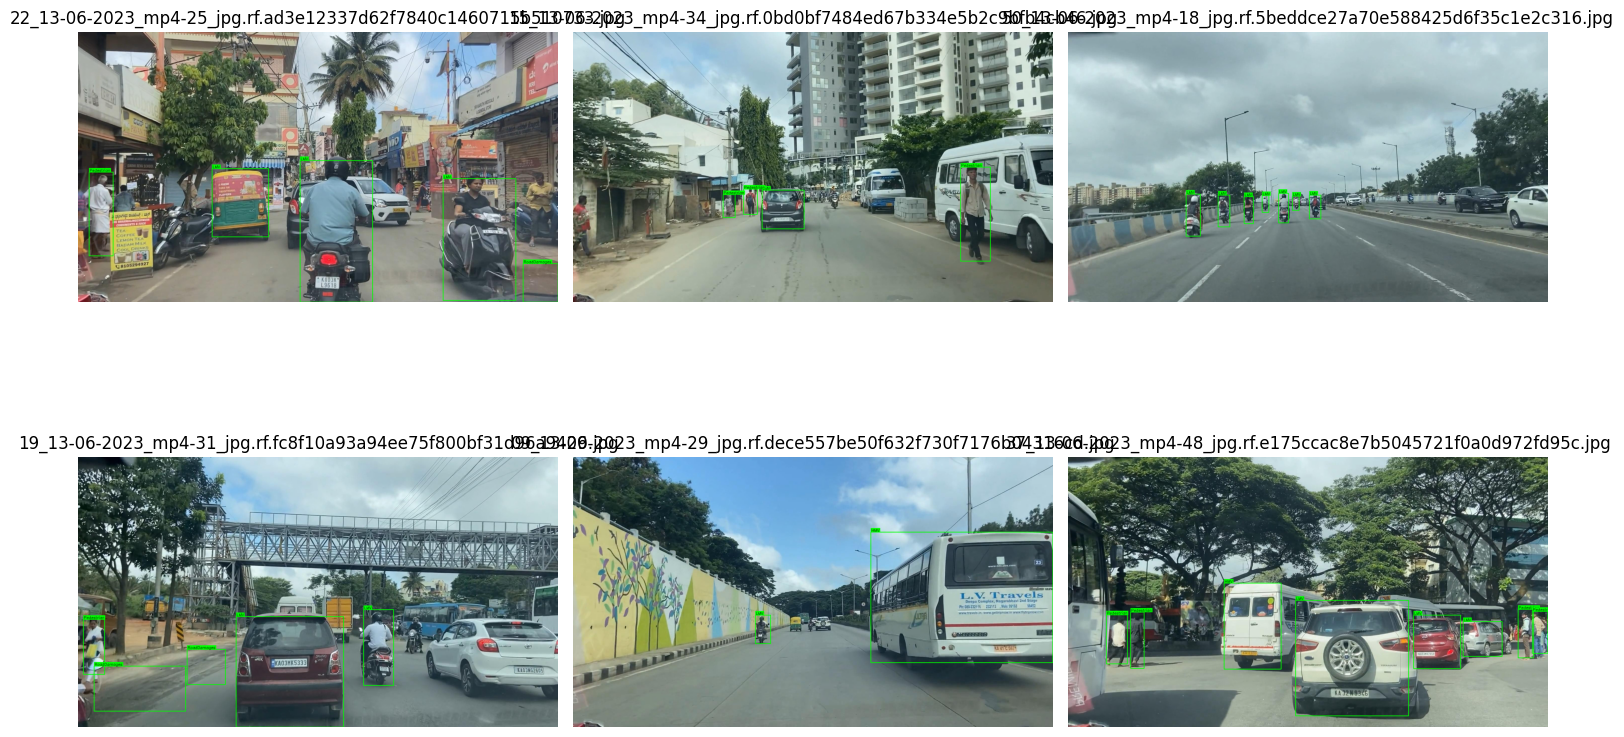

In [ ]:
# Cell 6 — EDA + labeled visualization (robust to RadRoad layout)

from pathlib import Path
import yaml, random, glob, cv2, matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Set your dataset root (the folder that contains data.yaml and split folders)
DATASET_ROOT = Path("/root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images")
yaml_path = DATASET_ROOT / "data.yaml"
assert yaml_path.exists(), f"data.yaml not found at {yaml_path}"

with open(yaml_path, "r") as f:
    ycfg = yaml.safe_load(f)

base_dir = yaml_path.parent.resolve()  # .../versions/3/images

def resolve_split(split_key: str) -> Path:
    """Resolve split images dir, trying YAML path first, then common fallbacks."""
    # 1) Try YAML (relative to data.yaml)
    p_yaml = (base_dir / ycfg[split_key]).resolve()
    # 2) Fallbacks we’ve seen in this dataset
    p_inside_images = base_dir / split_key / "images"         # .../images/train/images
    p_sibling       = base_dir.parent / split_key / "images"  # .../versions/3/train/images

    for cand in [p_yaml, p_inside_images, p_sibling]:
        if cand.exists() and any(cand.glob("*")):
            print(f"[{split_key}] using: {cand}")
            return cand

    # If none had files, still return YAML-resolved to keep downstream code working
    print(f"[{split_key}] WARNING: no files found; last tried {p_yaml}")
    return p_yaml

train_img_dir = resolve_split("train")
val_img_dir   = resolve_split("val")
test_img_dir  = resolve_split("test")

train_lbl_dir = train_img_dir.parent / "labels"
val_lbl_dir   = val_img_dir.parent / "labels"
test_lbl_dir  = test_img_dir.parent / "labels"

# Sanity counts
def count_files(p: Path, pattern="*"):
    return len(list(p.glob(pattern))) if p.exists() else 0

print("\nCounts:")
print(f" Train — images: {count_files(train_img_dir)} | labels: {count_files(train_lbl_dir, '*.txt')}")
print(f" Valid — images: {count_files(val_img_dir)}   | labels: {count_files(val_lbl_dir, '*.txt')}")
print(f" Test  — images: {count_files(test_img_dir)}  | labels: {count_files(test_lbl_dir, '*.txt')}")

# Classes
class_names = ycfg["names"]; num_classes = ycfg["nc"]
print(f"\nClasses ({num_classes}): {class_names}")

# Class frequency on train
cls_counter = Counter()
for lf in train_lbl_dir.glob("*.txt"):
    with open(lf, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                cls_counter[int(parts[0])] += 1

print("\nTrain label counts per class:")
for cid, cname in enumerate(class_names):
    print(f"{cid:>2} {cname:<15}: {cls_counter.get(cid, 0)}")

# Visualization
def draw_yolo_labels(img_path: Path, lbl_path: Path, names, color=(0,255,0), thickness=2):
    img = cv2.imread(str(img_path))
    if img is None:
        return None
    H, W = img.shape[:2]
    if lbl_path.exists():
        with open(lbl_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5:
                    continue
                cls, cx, cy, w, h = int(parts[0]), *map(float, parts[1:5])
                x1, y1 = int((cx - w/2) * W), int((cy - h/2) * H)
                x2, y2 = int((cx + w/2) * W), int((cy + h/2) * H)
                cv2.rectangle(img, (x1,y1), (x2,y2), color, thickness)
                label = names[cls] if 0 <= cls < len(names) else str(cls)
                t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
                cv2.rectangle(img, (x1, y1 - t_size[1] - 4), (x1 + t_size[0] + 4, y1), color, -1)
                cv2.putText(img, label, (x1 + 2, y1 - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show a few labeled train images
all_train_imgs = sorted(train_img_dir.glob("*"))
N = min(6, len(all_train_imgs))
if N == 0:
    print("\nNo train images found after resolution. Double-check the dataset path above.")
else:
    import math
    cols, rows = 3, math.ceil(N/3)
    plt.figure(figsize=(15, 5*rows))
    sample = random.sample(all_train_imgs, k=N)
    for i, img_path in enumerate(sample, 1):
        lbl_path = train_lbl_dir / (img_path.stem + ".txt")
        vis = draw_yolo_labels(img_path, lbl_path, class_names)
        if vis is None: continue
        plt.subplot(rows, cols, i)
        plt.imshow(vis); plt.title(img_path.name); plt.axis("off")
    plt.tight_layout(); plt.show()


In [ ]:
# Cell 6b — Fix YAML paths (make absolute) and re-check counts

from pathlib import Path
import yaml, os

DATASET_ROOT = Path("/root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images")
orig_yaml = DATASET_ROOT / "data.yaml"

with open(orig_yaml, "r") as f:
    ycfg = yaml.safe_load(f)

names = ycfg["names"]
nc = ycfg["nc"]

def pick_dir(candidates):
    for p in candidates:
        p = Path(p)
        if p.exists() and any(p.glob("*")):
            return p.resolve()
    return None

# Detect train/val/test images dirs
train_images = pick_dir([
    DATASET_ROOT/"train/images",
    DATASET_ROOT.parent/"train/images",
    (orig_yaml.parent/ycfg["train"]).resolve()
])

val_images = pick_dir([
    DATASET_ROOT/"valid/images",         # common actual layout
    DATASET_ROOT/"val/images",           # rare alt
    DATASET_ROOT.parent/"valid/images",
    DATASET_ROOT.parent/"val/images",
    (orig_yaml.parent/ycfg["val"]).resolve()
])

test_images = pick_dir([
    DATASET_ROOT/"test/images",
    DATASET_ROOT.parent/"test/images",
    (orig_yaml.parent/ycfg["test"]).resolve()
])

assert train_images is not None, "Could not locate train/images"
assert test_images  is not None, "Could not locate test/images"
if val_images is None:
    print("WARNING: valid/images not found; will reuse test as val.")
    val_images = test_images

train_labels = train_images.parent/"labels"
val_labels   = val_images.parent/"labels"
test_labels  = test_images.parent/"labels"

print("Resolved splits:")
print(" train_images:", train_images)
print(" val_images:  ", val_images)
print(" test_images: ", test_images)

def count(directory_path, pattern="*"):
    p = Path(directory_path)
    return len(list(p.glob(pattern))) if p.exists() else 0

print("\nCounts (after fix):")
print(f" Train — images: {count(train_images)} | labels: {count(train_labels, '*.txt')}")
print(f" Valid — images: {count(val_images)}   | labels: {count(val_labels, '*.txt')}")
print(f" Test  — images: {count(test_images)}  | labels: {count(test_labels, '*.txt')}")

# Write a clean, absolute YAML Ultralytics can use directly
fixed_yaml = Path.cwd() / "data_radroad.yaml"
cfg = {
    "train": str(train_images),
    "val":   str(val_images),
    "test":  str(test_images),
    "nc":    nc,
    "names": names
}
with open(fixed_yaml, "w") as f:
    yaml.safe_dump(cfg, f, sort_keys=False)

print("\nWrote:", fixed_yaml.resolve())
print(fixed_yaml.read_text())

Resolved splits:
 train_images: /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images/train/images
 val_images:   /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images/valid/images
 test_images:  /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images/test/images

Counts (after fix):
 Train — images: 5843 | labels: 5843
 Valid — images: 1288   | labels: 1288
 Test  — images: 1263  | labels: 1263

Wrote: /content/data_radroad.yaml
train: /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images/train/images
val: /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images/valid/images
test: /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images/test/images
nc: 6
names:
- HMV
- LMV
- Pedestrian
- RoadDamages
- SpeedBump
- UnsurfacedRoad



In [ ]:
# Cell 7 — Train a baseline YOLOv8n on RadRoad

from ultralytics import YOLO

yaml_path = "/content/data_radroad.yaml"  # dataset config
model = YOLO("yolov8n.pt")                # still start with n-model; upgrade later to s/m if stable

results = model.train(
    data=yaml_path,
    imgsz=896,          # larger image → more GPU use, helps small road anomalies
    epochs=40,          # small bump for better convergence
    batch=-1,           # auto-selects largest batch that fits in VRAM
    lr0=0.01,           # standard SGD learning rate
    optimizer="SGD",    # "auto" or "AdamW" also fine
    patience=10,        # early stop if validation stalls
    device=0,           # use GPU
    workers=6,          # more dataloader threads for Colab Pro
    cache="ram",        # cache images in RAM → faster data loading
    project="radroad_runs",
    name="yolov8n_highutil",
    verbose=True,
)

# Optional: quick validation summary after training
metrics = model.val(data=yaml_path, imgsz=736, device=0)
print(metrics)


Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data_radroad.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_highutil, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose

In [ ]:
from ultralytics import YOLO
model = YOLO("radroad_runs/yolov8n_highutil/weights/best.pt")
model.plot_results()  # plots losses and mAP curves from results.csv


In [17]:
# Practice Cell — Quick check of trained weights (best.pt)

from ultralytics import YOLO
from pathlib import Path
import yaml, random, cv2, matplotlib.pyplot as plt

# Paths to your model and dataset config
WEIGHTS = Path("/content/best.pt")
YAML = Path("/content/data_radroad.yaml")

assert WEIGHTS.exists(), f"Missing weights: {WEIGHTS}"
assert YAML.exists(), f"Missing YAML: {YAML}"

# Load model
model = YOLO(str(WEIGHTS))
print("Loaded model from:", WEIGHTS)

# Quick validation (no plots, small image size for speed)
metrics = model.val(data=str(YAML), split="test", imgsz=640, plots=False, device=0, workers=4)
print("\nQuick test metrics:")
print(f"mAP@50: {metrics.box.map50:.3f} | mAP@50–95: {metrics.box.map:.3f} | "
      f"Precision: {metrics.box.mp:.3f} | Recall: {metrics.box.mr:.3f}")

# Pick a few random test images for visual check
ycfg = yaml.safe_load(YAML.read_text())
test_dir = Path(ycfg["test"]).resolve()
all_imgs = [p for p in test_dir.glob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png"}]
sample = random.sample(all_imgs, k=min(4, len(all_imgs)))

print("\nRunning quick predictions...")
preds = model.predict(source=[str(p) for p in sample], imgsz=640, conf=0.3, save=False, verbose=False)

# Display predictions inline
plt.figure(figsize=(15, 6))
for i, (result, img_path) in enumerate(zip(preds, sample), 1):
    img = result.plot()  # Ultralytics draws boxes on the image
    plt.subplot(1, len(sample), i)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(img_path.name)
    plt.axis("off")
plt.tight_layout()
plt.show()

Loaded model from: /content/best.pt


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# Clean install compatible wheels and force a runtime restart

# 1) Uninstall conflicting wheels
!pip uninstall -y numpy ultralytics opencv-python roboflow

# 2) Reinstall compatible versions (works well with Torch 2.8 in Colab)
!pip install -q --no-cache-dir --force-reinstall \
  "numpy==1.26.4" \
  "ultralytics==8.3.204" \
  "opencv-python==4.10.0.84" \
  "roboflow==1.1.47"

import os
os.kill(os.getpid(), 9)  # HARD RESTART so C-extensions reload


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: ultralytics 8.3.204
Uninstalling ultralytics-8.3.204:
  Successfully uninstalled ultralytics-8.3.204
Found existing installation: opencv-python 4.10.0.84
Uninstalling opencv-python-4.10.0.84:
  Successfully uninstalled opencv-python-4.10.0.84
Found existing installation: roboflow 1.1.47
Uninstalling roboflow-1.1.47:
  Successfully uninstalled roboflow-1.1.47
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
torchaudio 2.5.1+cu121 requires torch==2.5.1, but you have torch 2.8.0 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >

Loaded: /content/best.pt
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu128 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 63.0±27.8 MB/s, size: 224.2 KB)
val: Scanning /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images/test/labels... 1263 images, 13 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1263/1263 450.0it/s 2.8s
val: New cache created: /root/.cache/kagglehub/datasets/rohitsuresh15/radroad-anomaly-detection/versions/3/images/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 79/79 4.3it/s 18.2s
                   all       1263       4504       0.84      0.748      0.819       0.47
                   HMV        504        647      0.909      0.966      0.981      0.727
                   LMV        928       2158      0.911       0.91      0.952      0.612
 

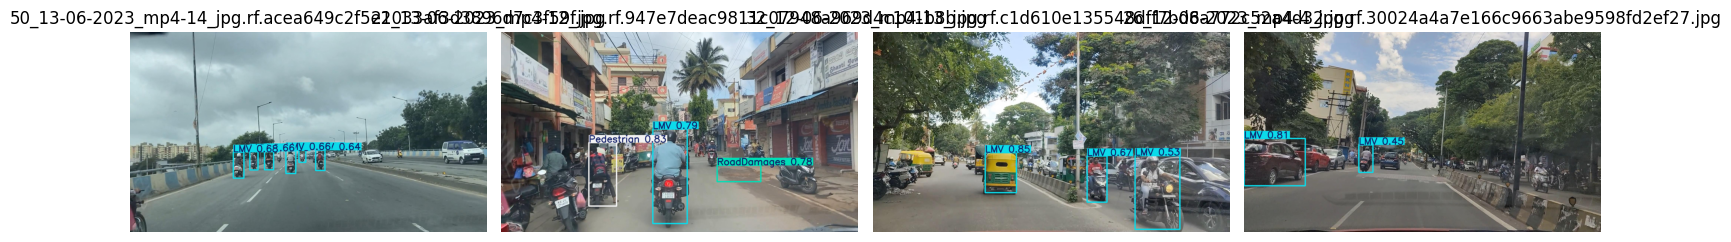

In [1]:
# Quick check of trained weights after restart

from ultralytics import YOLO
from pathlib import Path
import yaml, random, cv2, matplotlib.pyplot as plt

WEIGHTS = Path("/content/best.pt")
YAML    = Path("/content/data_radroad.yaml")
assert WEIGHTS.exists(), f"Missing weights: {WEIGHTS}"
assert YAML.exists(),    f"Missing YAML: {YAML}"

model = YOLO(str(WEIGHTS))
print("Loaded:", WEIGHTS)

# Fast validation (no plots)
metrics = model.val(data=str(YAML), split="test", imgsz=640, plots=False, device=0, workers=4)
print(f"\nQuick test metrics -> mAP@50: {metrics.box.map50:.3f} | "
      f"mAP@50-95: {metrics.box.map:.3f} | Precision: {metrics.box.mp:.3f} | Recall: {metrics.box.mr:.3f}")

# Random image preds (not saved)
test_dir = Path(yaml.safe_load(YAML.read_text())["test"]).resolve()
imgs = [p for p in test_dir.glob("*") if p.suffix.lower() in {".jpg",".jpeg",".png"}]
sample = random.sample(imgs, k=min(4, len(imgs)))

preds = model.predict(source=[str(p) for p in sample], imgsz=640, conf=0.3, save=False, verbose=False)

plt.figure(figsize=(15, 6))
for i, (res, path) in enumerate(zip(preds, sample), 1):
    vis = res.plot()
    plt.subplot(1, len(sample), i)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(path.name); plt.axis("off")
plt.tight_layout(); plt.show()


### Test Evaluation Summary (best.pt)

**Overall performance**
- **mAP@50:** 0.819  
- **mAP@50–95:** 0.470  
- **Precision:** 0.840  
- **Recall:** 0.748  
- **Throughput (per image):** ~2.6 ms inference + 1.7 ms postprocess (T4, imgsz≈640/896)

**Per-class (mAP@50 shown; AP50–95 trend in comments)**
- **HMV:** 0.981 (AP50–95: 0.727) — Excellent; very high P/R.
- **LMV:** 0.952 (0.612) — Strong; slight drop at higher IoU thresholds.
- **Pedestrian:** 0.891 (0.474) — Good; boxes moderately tighter needed for higher IoUs.
- **RoadDamages:** 0.558 (0.239) — Weakest; likely small/ambiguous features, label variability.
- **SpeedBump:** 0.798 (0.397) — Solid for small, low-contrast targets.
- **UnsurfacedRoad:** 0.735 (0.369) — Decent but room to improve boundary consistency.

**Interpretation**
- The model generalizes very well to **vehicles** and **pedestrians**; detections are both accurate and tight at IoU 0.5, with reasonable degradation at stricter IoUs.
- **RoadDamages** underperforms relative to other classes (low recall and AP50–95), which is common due to subtle textures, variability, and small object sizes.

**Targeted next steps**
1. **Class-focused augmentation:** increase texture/lighting variation for damages; try `hsv_*` and slight `scale` increases; keep geometric warps conservative.
2. **Resolution/model size:** bump `imgsz` to 896–960 and/or upgrade to `yolov8s.pt`; retrain for 60–100 epochs with early stopping.
3. **Sampling & labels:** oversample or weight the **RoadDamages** class; audit labels for consistency (boundary tightness).
4. **Threshold tuning:** for deployment, consider class-specific `conf` (lower for damages) to trade precision for recall.

**Bottom line**
- This is a **strong baseline** for a nano model (YOLOv8n). With modest training/architecture tweaks focused on **RoadDamages**, you can likely push mAP@50 upward while improving difficult cases.
